# Raster to Polygons
Michael Dear  
https://github.com/mjdear68  
August 2024

**Objective**: Convert a raster classification map to polygons.

**Method**: Three methods are tested for speed and effectiveness.

## Import and prepare the test data

Import the required libraries.

In [112]:
import xarray as xr
import rioxarray
import numpy as np
import pandas as pd
import geopandas as gpd

Load the raster data to be converted to polygons.

In [113]:
da = rioxarray.open_rasterio('input/test.tiff', default_name='class')
da

<xarray.DataArray 'class' (band: 1, y: 100, x: 100)>
[10000 values with dtype=uint8]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 1.821e+06 1.821e+06 ... 1.824e+06 1.824e+06
  * y            (y) float64 -3.723e+06 -3.723e+06 ... -3.726e+06 -3.726e+06
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      SVM_Class_linear

Convert the xarray dataarray to a Pandas DataFrame of points.

In [114]:
df = da.to_dataframe().reset_index()
df.head()

,band,y,x,spatial_ref,class
0,1,-3722685.0,1821465.0,0,5
1,1,-3722685.0,1821495.0,0,4
2,1,-3722685.0,1821525.0,0,4
3,1,-3722685.0,1821555.0,0,5
4,1,-3722685.0,1821585.0,0,5


Convert the data frame to a GeoDataFrame.

In [115]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x, df.y))
gdf.head()

,band,y,x,spatial_ref,class,geometry
0,1,-3722685.0,1821465.0,0,5,POINT (1821465.000 -3722685.000)
1,1,-3722685.0,1821495.0,0,4,POINT (1821495.000 -3722685.000)
2,1,-3722685.0,1821525.0,0,4,POINT (1821525.000 -3722685.000)
3,1,-3722685.0,1821555.0,0,5,POINT (1821555.000 -3722685.000)
4,1,-3722685.0,1821585.0,0,5,POINT (1821585.000 -3722685.000)


Create a sorted list of class numbers.

In [116]:
class_nums = np.sort(gdf['class'].unique())
class_nums

array([1, 2, 3, 4, 5, 6], dtype=uint8)

## Method 1
Based on https://gis.stackexchange.com/a/439834.

This is not a useful method because it creates overlapping polygons between classes. It is fast, however.

Import the required libraries and functions.

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

from sklearn.cluster import DBSCAN
from shapely.ops import unary_union

Run all the steps, iterating over all the classes.

In [130]:
gdfs = []
for class_num in class_nums:
    gdf_this = gdf[gdf['class']==class_num].reset_index().drop('index', axis=1)
    coords = gdf_this[['x','y']].values
    db = DBSCAN(eps=31, min_samples=1).fit(coords)
    cluster_labels = pd.Series(db.labels_).rename('cluster')
    gdf_this['cluster'] = db.labels_

    #Create convex hulls from each cluster
    hulls = [] #A list to hold clusterids and convex hull geometries
    for clusterid, frame in gdf_this.loc[gdf_this['cluster']!=-1].groupby('cluster'): #For each cluster group except -1
        geom = unary_union(frame.geometry.tolist()).convex_hull #Create one multipoint and convex hull it
        hulls.append([clusterid, geom])
        
    df_this = pd.DataFrame.from_records(data=hulls, columns=['cluster','geometry'])
    gdf_this_out = gpd.GeoDataFrame(data=df_this, geometry=df_this['geometry'], crs=gdf_this.crs)
    gdf_this_out = gdf_this_out[gdf_this_out.geometry.geom_type=='Polygon']
    
    # Combine polygons into a single mulipolygon
    # https://stackoverflow.com/a/74991509/8299958
    # https://gis.stackexchange.com/a/413810
    gdf_this_out = gdf_this_out.dissolve()

    # append to gdfs
    gdfs.append(gdf_this_out)

# Concatenate gdfs
gdf_method_1 = pd.concat(gdfs)
gdf_method_1['class'] = class_nums

<Axes: >

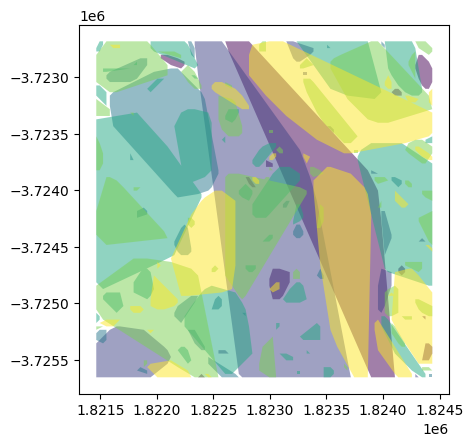

In [131]:
gdf_method_1.plot(column='class', alpha=0.5)

### Save to file

In [132]:
# Save to file
gdf_method_1.to_file('output/method_1_polygons.geojson', driver='GeoJSON')

## Method 2
Repeat the following for each class in the dataset.
1. Create GoeDataFrame of points
2. Buffer the points
3. Get the bounds of the buffered points
4. Convert the bounds of a point to a polygon
5. Merge all touching "buffer polygons" into individual polygons

References
* https://stackoverflow.com/a/72310089/8299958
* https://stackoverflow.com/a/68762419/8299958

### Imports

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import rioxarray
import numpy as np

from shapely.geometry import Polygon
from shapely.ops import unary_union

### Proof of concept

In [97]:
df = pd.DataFrame({'x': [0,1,3], 'y': [1,1,1]})

In [98]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['x'], df['y']))

<Axes: >

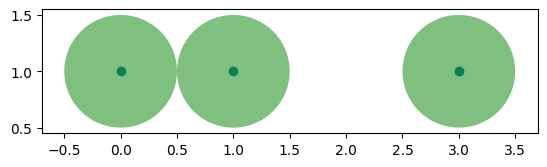

In [99]:
fig, ax = plt.subplots()
gdf.plot(ax=ax)
gdf.buffer(0.5).plot(ax=ax, color='green', alpha=0.5)

[(-0.5, 0.5), (0.5, 0.5), (0.5, 1.5), (-0.5, 1.5)]
[(0.5, 0.5), (1.5, 0.5), (1.5, 1.5), (0.5, 1.5)]
[(2.5, 0.5), (3.5, 0.5), (3.5, 1.5), (2.5, 1.5)]


<Axes: >

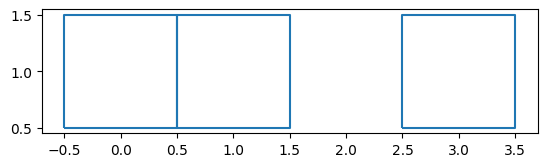

In [108]:
# https://stackoverflow.com/a/72310089/8299958

polygons = []

for row in gdf.index:
    # Get the X, Y coordinates of the point buffer bounds
    X1, Y1, X2, Y2 = gdf.iloc[[row]].buffer(0.5).total_bounds
    
    # Create the polygon; anti-clockwise from bottom-left
    polygon = [(X1, Y1), (X2, Y1), (X2, Y2), (X1, Y2)]
    print(polygon)
    polygons.append(Polygon(polygon))

gdf_poly = gpd.GeoDataFrame(geometry=polygons)

gdf_poly.boundary.plot()

<Axes: >

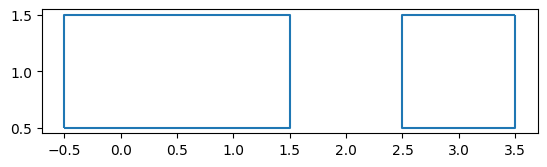

In [105]:
# Dissolve to create multipolygon with touching geometries merged
gdf_dissolved = gdf_poly.dissolve()
gdf_dissolved.boundary.plot()

In [106]:
gdf_dissolved.area

0    3.0
dtype: float64

### Apply the method to the test data

In [27]:
%%time

class_gdfs = []
classes = np.sort(gdf['class'].unique())

for cl in classes:
    # Intialise the list for the pixel polygons
    pixel_polygons = []
    for row in gdf[gdf['class']==cl].index:
        # Get the X, Y coordinates of the point buffer bounds
        X1, Y1, X2, Y2 = gdf.iloc[[row]].buffer(15).total_bounds
        
        # Create the polygon; anti-clockwise from bottom-left
        polygon = [(X1, Y1), (X2, Y1), (X2, Y2), (X1, Y2)]
        
        # Append pixel polygon to output list
        pixel_polygons.append(Polygon(polygon))
    
    # Convert pixel_polygons to gdf and append to class_gdfs
    # For unary_union() see https://stackoverflow.com/a/40386377/8299958
    class_gdfs.append(gpd.GeoSeries(unary_union(pixel_polygons)))
   
# Create the final GeoDataFrame
gdf_poly = gpd.GeoDataFrame(geometry=pd.concat(class_gdfs))

# Include a classes column
gdf_poly['class']=classes

# Set the crs to the data array crs
gdf_poly = gdf_poly.set_crs(da.rio.crs)

CPU times: total: 6.16 s
Wall time: 7.37 s


### Check the results

In [28]:
gdf_poly

,geometry,class
0,"MULTIPOLYGON (((1822170.000 -3725640.000, 1822...",1
0,"MULTIPOLYGON (((1821600.000 -3725670.000, 1821...",2
0,"MULTIPOLYGON (((1821450.000 -3725250.000, 1821...",3
0,"MULTIPOLYGON (((1821510.000 -3725160.000, 1821...",4
0,"MULTIPOLYGON (((1821480.000 -3725220.000, 1821...",5
0,"MULTIPOLYGON (((1821960.000 -3725610.000, 1821...",6


<Axes: >

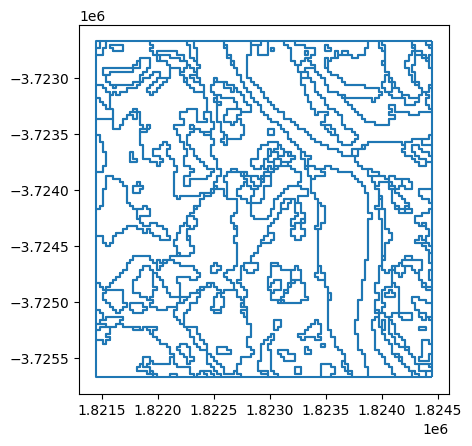

In [29]:
gdf_poly.boundary.plot()

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

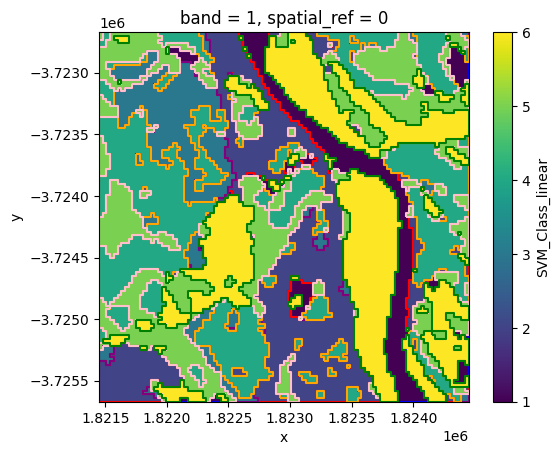

In [30]:
fig, ax = plt.subplots()
da.plot(ax=ax)
gdf_poly.boundary.plot(ax=ax, color=['blue','red','purple','orange','pink','green'], alpha=1)

### Write to file

In [32]:
gdf_poly.to_file('output/method_2_polygons.geojson', driver='GeoJSON')

In [276]:
gdf_poly.crs